# Knox space-time interaction statistic

In [1]:
%load_ext autoreload
%autoreload 2

## Current Implementation (to be deprecated)

In [2]:
import pointpats

/home/serge/mambaforge/envs/pointpats/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/serge/mambaforge/envs/pointpats/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/serge/mambaforge/envs/pointpats/lib/python3.11/site-packa

In [3]:
import libpysal

In [4]:
path = libpysal.examples.get_path('burkitt.shp')

In [5]:
from pointpats import SpaceTimeEvents, knox

In [6]:
events = SpaceTimeEvents(path, 'T')

/home/serge/mambaforge/envs/pointpats/lib/python3.11/site-packages/libpysal/cg/shapes.py:103: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [7]:
events

In [8]:
import numpy

In [9]:
knox?

Signature: knox(s_coords, t_coords, delta, tau, permutations=99, debug=False)
Docstring:
Knox test for spatio-temporal interaction. :cite:`Knox:1964`

Parameters
----------
s_coords        : array
                  (n, 2), spatial coordinates.
t_coords        : array
                  (n, 1), temporal coordinates.
delta           : float
                  threshold for proximity in space.
tau             : float
                  threshold for proximity in time.
permutations    : int, optional
                  the number of permutations used to establish pseudo-
                  significance (the default is 99).
debug           : bool, optional
                  if true, debugging information is printed (the default is
                  False).

Returns
-------
knox_result     : dictionary
                  contains the statistic (stat) for the test and the
                  associated p-value (pvalue).
stat            : float
                  value of the knox test for the dataset.

In [10]:
events.space

array([[300., 302.],
       [291., 270.],
       [326., 263.],
       [299., 376.],
       [267., 327.],
       [266., 356.],
       [267., 345.],
       [262., 338.],
       [268., 335.],
       [335., 275.],
       [302., 272.],
       [301., 304.],
       [302., 272.],
       [324., 337.],
       [260., 338.],
       [306., 385.],
       [284., 362.],
       [293., 332.],
       [274., 353.],
       [263., 333.],
       [307., 386.],
       [274., 357.],
       [297., 282.],
       [288., 365.],
       [283., 366.],
       [290., 352.],
       [284., 341.],
       [286., 341.],
       [282., 350.],
       [292., 278.],
       [305., 381.],
       [298., 378.],
       [299., 381.],
       [287., 342.],
       [276., 380.],
       [261., 345.],
       [273., 347.],
       [284., 357.],
       [266., 361.],
       [285., 360.],
       [278., 350.],
       [305., 321.],
       [293., 332.],
       [297., 375.],
       [332., 273.],
       [256., 345.],
       [275., 357.],
       [267.,

In [11]:
events.time

array([[4.130e+02, 1.000e+00],
       [4.720e+02, 1.000e+00],
       [5.110e+02, 1.000e+00],
       [6.890e+02, 1.000e+00],
       [7.300e+02, 1.000e+00],
       [8.470e+02, 1.000e+00],
       [8.710e+02, 1.000e+00],
       [8.990e+02, 1.000e+00],
       [9.210e+02, 1.000e+00],
       [1.134e+03, 1.000e+00],
       [1.190e+03, 1.000e+00],
       [1.214e+03, 1.000e+00],
       [1.224e+03, 1.000e+00],
       [1.322e+03, 1.000e+00],
       [1.399e+03, 1.000e+00],
       [1.480e+03, 1.000e+00],
       [1.503e+03, 1.000e+00],
       [1.549e+03, 1.000e+00],
       [1.567e+03, 1.000e+00],
       [1.607e+03, 1.000e+00],
       [1.615e+03, 1.000e+00],
       [1.657e+03, 1.000e+00],
       [1.688e+03, 1.000e+00],
       [1.695e+03, 1.000e+00],
       [1.714e+03, 1.000e+00],
       [1.811e+03, 1.000e+00],
       [1.813e+03, 1.000e+00],
       [1.910e+03, 1.000e+00],
       [1.986e+03, 1.000e+00],
       [1.996e+03, 1.000e+00],
       [2.049e+03, 1.000e+00],
       [2.053e+03, 1.000e+00],
       [

In [12]:
numpy.random.seed(100)

In [13]:
result = knox(events.space, events.t, delta=20, tau=5, permutations=99)

/tmp/ipykernel_3204526/489981337.py:1: DeprecationWarning: This function is deprecated. Use Knox
  result = knox(events.space, events.t, delta=20, tau=5, permutations=99)


In [14]:
result

{'stat': 13, 'pvalue': array([0.17])}

In [15]:
events.space.shape

(188, 2)

In [16]:
events.t.shape

(188, 1)

## New Implementation

- Global Knox with analytical inference
- Global Knox with space/time distance queries
- Local Knox with analytical inference
- Local Knox with conditional permutations
- Better Reporting

In [17]:
import geopandas

In [18]:
df = geopandas.read_file(path)

In [19]:
df.head()

,ID,X,Y,T,AGE,DATE,geometry
0,1.0,300.0,302.0,413.0,22.0,1901-02-16,POINT (300.000 302.000)
1,2.0,291.0,270.0,472.0,5.0,1901-04-16,POINT (291.000 270.000)
2,3.0,326.0,263.0,511.0,12.0,1901-05-25,POINT (326.000 263.000)
3,4.0,299.0,376.0,689.0,6.0,1901-11-19,POINT (299.000 376.000)
4,5.0,267.0,327.0,730.0,4.0,1901-12-30,POINT (267.000 327.000)


<Axes: >

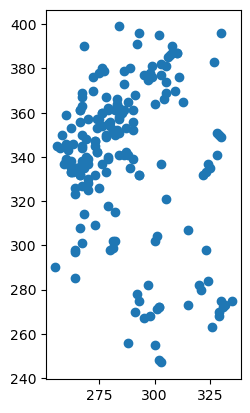

In [20]:
df.plot()

In [21]:
from pointpats.spacetime import Knox

In [22]:
results = Knox(df[['X', 'Y']], df[["T"]], delta=20, tau=5)

In [23]:
results.statistic_

13

In [24]:
results.p_sim

0.28

In [25]:
results.p_poisson

0.14624558197140414

In [26]:
numpy.random.seed(123456)
results = Knox(df[['X', 'Y']], df[["T"]], delta=20, tau=5,keep=True)

In [27]:
results.observed

array([[1.300e+01, 3.416e+03],
       [3.900e+01, 1.411e+04]])

In [28]:
results.expected

array([[1.01438161e+01, 3.41885618e+03],
       [4.18561839e+01, 1.41071438e+04]])

In [29]:
results.keep

True

In [30]:
results.p_sim

0.24

In [31]:
results = Knox(df[['X', 'Y']], df[["T"]], delta=20, tau=5, keep=True)

In [32]:
hasattr(results, "sim")

True

In [33]:
results.sim

array([16., 10., 13.,  7., 10.,  9.,  8., 10., 10.,  9.,  7., 14.,  9.,
       11., 11., 13.,  8.,  9.,  8.,  8.,  8.,  7.,  8., 13.,  8., 12.,
       10., 11.,  9., 12.,  8.,  6.,  9., 11., 12., 16., 14., 11., 13.,
       12., 11.,  8., 13.,  7., 10.,  4.,  8., 14.,  9., 12., 12.,  6.,
        8., 10.,  8.,  9.,  7.,  8., 11., 12., 10., 17., 10.,  8., 12.,
       13.,  9.,  8.,  9., 10., 11.,  6., 10., 13., 17., 11.,  8.,  8.,
       10.,  7., 10.,  9., 13., 10.,  7., 13.,  6.,  9., 11.,  9., 14.,
       14.,  6., 11., 13., 12., 10., 10., 11.])

In [35]:
from pointpats.spacetime import KnoxLocal
numpy.random.seed(12345)

In [36]:
lres = results = KnoxLocal(df[['X', 'Y']], df[["T"]], delta=20, tau=5)

In [37]:
lres.statistic_.shape

(188,)

In [38]:
gt0ids = numpy.where(lres.nsti>0)
gt0ids

(array([ 25,  26,  30,  31,  35,  36,  41,  42,  46,  47,  51,  52, 102,
        103, 116, 118, 122, 123, 137, 138, 139, 140, 158, 159, 162, 163]),)

In [39]:
lres.nsti[gt0ids]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [40]:
lres.p_hypergeom[gt0ids]

array([0.1348993 , 0.14220663, 0.07335085, 0.08400282, 0.1494317 ,
       0.21524073, 0.0175806 , 0.04599869, 0.17523687, 0.18209188,
       0.19111321, 0.16830444, 0.13734428, 0.14703242, 0.06796364,
       0.03192559, 0.13734428, 0.17523687, 0.12998154, 0.1933476 ,
       0.13244507, 0.13244507, 0.12502644, 0.14703242, 0.12502644,
       0.12998154])

In [41]:
lres.p_sims[gt0ids]

array([0.3 , 0.33, 0.11, 0.17, 0.3 , 0.42, 0.06, 0.06, 0.33, 0.34, 0.36,
       0.38, 0.3 , 0.29, 0.41, 0.19, 0.31, 0.39, 0.18, 0.39, 0.48, 0.41,
       0.22, 0.41, 0.39, 0.32])